# Analyzing the original Polar data

In [315]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import stats
import re
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import glob
from scipy.stats import linregress
import calendar
from matplotlib.dates import DateFormatter

## Pre-process all files

In [316]:
folder_path = 'polar-original'

In [317]:
csv_files = [filename for filename in os.listdir(folder_path) if filename.endswith('.CSV')]

In [318]:
feature_data = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)

    watch_data = pd.read_csv(file_path, delimiter=',',low_memory=False, skiprows=2, usecols=[1,2,9])

    watch_timecode_pattern = r'\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}'
    watch_timecode_match = re.search(watch_timecode_pattern, file)
    watch_timecode_str = watch_timecode_match.group()
    watch_timecode_format = "%Y-%m-%d_%H-%M-%S" # This format should match the pattern in the filename
    watch_timecode_datetime = datetime.strptime(watch_timecode_str, watch_timecode_format)
    watch_timecode = pd.Timestamp(watch_timecode_datetime)

    # Convert the elapsed time in seconds to a timedelta
    watch_data['time_elapsed'] = pd.TimedeltaIndex(watch_data['Time'])

    # Add the timedelta to the start date to get the actual datetime
    watch_data['time_column'] = watch_timecode + watch_data['time_elapsed']

    # Remove the first 5 seconds of data
    watch_time_5_seconds_after = watch_data['time_column'].min() + pd.Timedelta(seconds=5)
    watch_data = watch_data[watch_data['time_column'] > watch_time_5_seconds_after]

    # Identify the time 500 seconds after the start
    watch_time_500_seconds_after = watch_data['time_column'].min() + pd.Timedelta(seconds=500)

    # Keep only the rows where the time is less than or equal to that
    watch_data = watch_data[watch_data['time_column'] <= watch_time_500_seconds_after]

    # Determine the reference time (first timestamp in the column)
    watch_reference_time = watch_data['time_column'].iloc[0]

    # Subtract the reference time from the entire column to get a timedelta
    watch_time_difference = watch_data['time_column'] - watch_reference_time

    # Convert the timedelta to seconds
    watch_data['Time'] = watch_time_difference.dt.total_seconds()
    watch_data

    watch_out_fn = str(watch_timecode_str) + '_watch.csv'
    watch_data.to_csv(watch_out_fn)
    
    print(file)

2023-09-10_15-39-29_polar.CSV
2023-07-01_11-07-38_polar.CSV
2023-01-12_12-35-29_polar.CSV
2023-02-11_12-19-02_polar.CSV
2023-09-02_12-10-48_polar.CSV
2023-06-05_12-57-04_polar.CSV
2023-01-23_14-24-22_polar.CSV
2023-01-19_13-44-45_polar.CSV
2023-10-07_16-29-01_polar.CSV
2023-05-01_11-26-56_polar.CSV
2023-03-21_12-32-48_polar.CSV
2023-01-29_17-46-25_polar.CSV
2023-06-14_14-34-16_polar.CSV
2023-07-14_14-35-57_polar.CSV
2023-10-08_15-01-45_polar.CSV
2023-04-01_14-28-27_polar.CSV
2023-08-14_13-01-01_polar.CSV
2023-05-02_17-22-34_polar.CSV
2023-10-06_14-44-41_polar.CSV
2023-12-13_10-30-04_polar.CSV
2023-09-26_12-06-44_polar.CSV
2023-05-21_14-01-21_polar.CSV
2023-08-01_12-11-11_polar.CSV
2023-08-08_11-51-14_polar.CSV
2023-06-08_14-41-44_polar.CSV
2023-11-21_12-44-03_polar.CSV
2023-01-20_15-51-56_polar.CSV
2023-05-05_11-40-37_polar.CSV
2023-03-07_12-23-07_polar.CSV
2023-12-09_12-31-07_polar.CSV
2023-11-27_11-21-31_polar.CSV
2023-02-14_17-20-00_polar.CSV
2023-09-09_10-51-34_polar.CSV
2023-09-05

## Analysis

In [342]:
folder_path = 'polar-clean'
csv_files = [filename for filename in os.listdir(folder_path) if filename.endswith('.csv')]

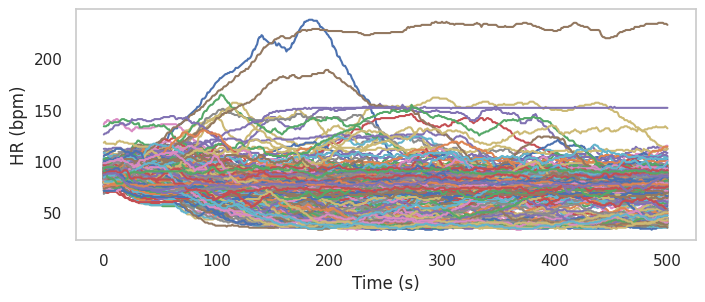

In [343]:
# Prepare an empty list to store all HR values
all_hr_data = []

plt.figure(figsize=(8, 3))

# Iterate over each CSV file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file and extract the HR column
        df = pd.read_csv(file_path)
        hr_data = df['HR (bpm)']
        
        # Plot HR values from current file
        plt.plot(hr_data)

# Set labels and title for the plot
plt.xlabel('Time (s)')
plt.ylabel('HR (bpm)')
#plt.title('HR (bpm) values')
# Turn off the grid
plt.grid(False)

plt.savefig('hr_all.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

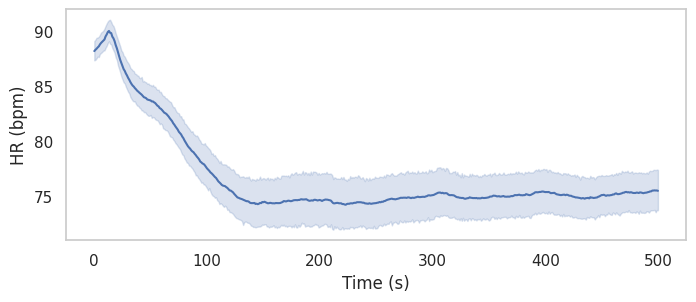

In [253]:
# Get a list of all CSV file paths in the folder
csv_files = glob.glob('polar-clean/*.csv')

# Load the CSV files into a single DataFrame
df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

# Drop rows with missing values
df.dropna(subset=['HR (bpm)', 'Time'], inplace=True)

# Perform linear regression
regression_model = LinearRegression()
regression_model.fit(df[['Time']], df['HR (bpm)'])

# Generate the predicted values based on the linear regression model
df['Predicted_HR'] = regression_model.predict(df[['Time']])

plt.figure(figsize=(8, 3))

# Plot scatterplot and regression line
sns.lineplot(x='Time', y='HR (bpm)', data=df)
#sns.lineplot(x='Time', y='Predicted_HR', data=df, color='red')

# Set plot title and labels
#plt.title('Linear Regression of HR values over Time')
plt.xlabel('Time (s)')
plt.ylabel('HR (bpm)')
# Turn off the grid
plt.grid(False)

plt.savefig('hr_all_mean.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


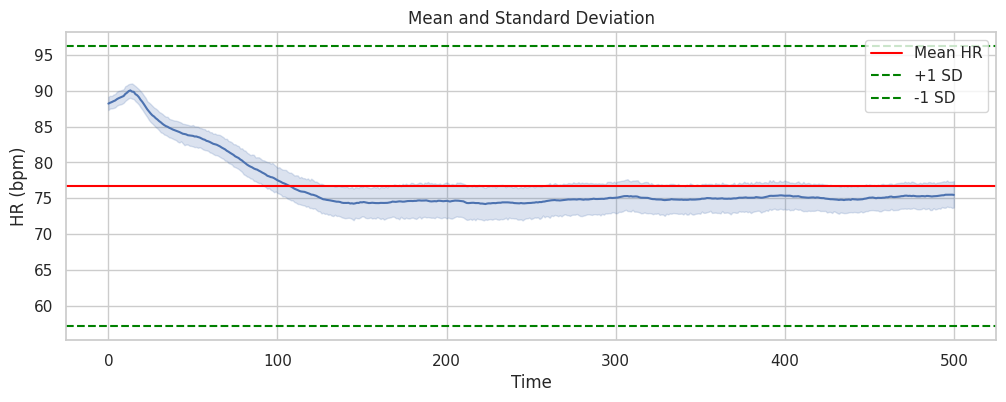

In [221]:
# Create an empty list to store the data from all the CSV files
data = []

# Loop through each CSV file, read the data, and append it to the list
for file in csv_files:
    df = pd.read_csv(file)
    data.append(df)

# Concatenate the data from all the CSV files into a single DataFrame
df = pd.concat(data, ignore_index=True)

# Drop with missing values
df.dropna(subset=['HR (bpm)', 'Time'], inplace=True)

# Calculate the mean and standard deviation
mean_hr = df['HR (bpm)'].mean()
std_hr = df['HR (bpm)'].std()

plt.figure(figsize=(12, 4))

# Plot the line chart
sns.lineplot(x='Time', y='HR (bpm)', data=df)

# Plot the mean line
plt.axhline(mean_hr, color='red', linestyle='-', label='Mean HR')

# Plot the upper and lower bounds for 1 standard deviation
plt.axhline(mean_hr + std_hr, color='green', linestyle='--', label='+1 SD')
plt.axhline(mean_hr - std_hr, color='green', linestyle='--', label='-1 SD')

# Set plot title and labels
plt.title('Mean and Standard Deviation')
plt.xlabel('Time')
plt.ylabel('HR (bpm)')

# Add legend
plt.legend()

# Display the plot
plt.show()


In [223]:
folder_path = 'polar-clean'
file_names = [filename for filename in os.listdir(folder_path) if filename.endswith('.csv')]

# Define a sorting function
def extract_numeric_part(file_name):
    numeric_part = re.findall(r'\d+', file_name)[0]
    return int(numeric_part)

# Sort the file names
file_names_sorted = sorted(file_names, key=extract_numeric_part)

file_names_sorted

['stillstanding001_watch.csv',
 'stillstanding002_watch.csv',
 'stillstanding003_watch.csv',
 'stillstanding004_watch.csv',
 'stillstanding005_watch.csv',
 'stillstanding006_watch.csv',
 'stillstanding007_watch.csv',
 'stillstanding008_watch.csv',
 'stillstanding009_watch.csv',
 'stillstanding010_watch.csv',
 'stillstanding011_watch.csv',
 'stillstanding012_watch.csv',
 'stillstanding013_watch.csv',
 'stillstanding014_watch.csv',
 'stillstanding015_watch.csv',
 'stillstanding016_watch.csv',
 'stillstanding017_watch.csv',
 'stillstanding018_watch.csv',
 'stillstanding019_watch.csv',
 'stillstanding020_watch.csv',
 'stillstanding021_watch.csv',
 'stillstanding022_watch.csv',
 'stillstanding023_watch.csv',
 'stillstanding024_watch.csv',
 'stillstanding025_watch.csv',
 'stillstanding026_watch.csv',
 'stillstanding027_watch.csv',
 'stillstanding028_watch.csv',
 'stillstanding029_watch.csv',
 'stillstanding030_watch.csv',
 'stillstanding031_watch.csv',
 'stillstanding032_watch.csv',
 'stills

In [262]:
data_frames = []  # list to store the DataFrames

# Read each CSV file into a DataFrame
for file_name in file_names_sorted:
    file_path = os.path.join(folder_path, file_name)
    data_frame = pd.read_csv(file_path)
    data_frames.append(data_frame)

concatenated_df = pd.concat(data_frames)  # concatenate all data frames
mean_value_all = concatenated_df["HR (bpm)"].mean(skipna=True)  # calculate mean of all data
std_value_all = concatenated_df["HR (bpm)"].std(skipna=True)  # calculate standard deviation of all data

# Calculate mean value per file
mean_values = []  # list to store mean values

for file_index, data_frame in enumerate(data_frames):
    mean_value = data_frame["HR (bpm)"].mean(skipna=True)  # skip NaN values
    mean_values.append(mean_value)


In [264]:
mean_value_all

76.67987650516213

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (12,) and arg 1 with shape (365,).

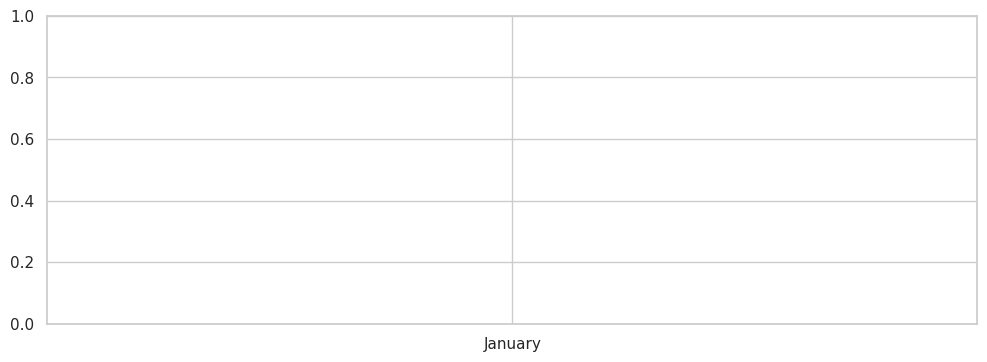

In [263]:
# Plot the mean values and linear regression line
plt.figure(figsize=(12, 4))
plt.bar(x, mean_values)
plt.axhline(y=mean_value_all, color='g', linestyle='--', label='Mean (All)')
plt.fill_between(x, mean_value_all-std_value_all, mean_value_all+std_value_all, alpha=0.3, color='g', label='Std (All)')
plt.xlabel("File Index")
plt.ylabel("Mean HR (bpm)")
plt.legend()
# Turn off the grid
plt.grid(False)
plt.savefig("hr_mean_values.png", dpi=600)
#plt.savefig("hr_mean_values.pdf")
plt.show()

In [231]:
mean_values

[72.02620967741936,
 84.55289421157684,
 61.75050301810865,
 80.38323353293413,
 93.26147704590818,
 75.2,
 91.28942115768463,
 87.53293413173652,
 69.61077844311377,
 74.01996007984032,
 75.27162977867204,
 78.30938123752495,
 63.64989939637827,
 73.78443113772455,
 76.04590818363273,
 81.8502994011976,
 74.25349301397206,
 67.44689378757515,
 92.22954091816368,
 80.44510978043913,
 86.37724550898204,
 78.77844311377245,
 85.54291417165669,
 92.8443113772455,
 82.9940119760479,
 86.08582834331337,
 88.2934131736527,
 85.2994011976048,
 73.19760479041916,
 82.21084337349397,
 141.11377245508982,
 82.60878243512974,
 90.01596806387225,
 88.15369261477046,
 89.64471057884232,
 82.93213572854292,
 75.78043912175649,
 82.42914171656686,
 85.70259481037924,
 80.31736526946108,
 79.01596806387225,
 81.42914171656686,
 56.191616766467064,
 81.63473053892216,
 70.42514970059881,
 67.46906187624751,
 77.85828343313374,
 88.15573770491804,
 78.87225548902195,
 84.6127744510978,
 80.2674650698602

In [233]:
# Create a sorting function that handles NaN values
def custom_sort(arr):
    return np.argsort(arr, kind='mergesort')[::-1]

# Sort the array using the custom sorting function
sorted_indices = custom_sort(mean_values)

# Print the mean values with index numbers
for i, idx in enumerate(sorted_indices):
    print(f"Index: {idx}, Mean value: {mean_values[idx]}")


Index: 292, Mean value: nan
Index: 185, Mean value: 204.06986027944112
Index: 30, Mean value: 141.11377245508982
Index: 230, Mean value: 122.00199600798403
Index: 153, Mean value: 121.96606786427145
Index: 243, Mean value: 121.7624750499002
Index: 56, Mean value: 116.261569416499
Index: 163, Mean value: 115.62874251497006
Index: 167, Mean value: 111.7624750499002
Index: 252, Mean value: 106.48902195608783
Index: 200, Mean value: 104.73852295409182
Index: 123, Mean value: 104.52495009980039
Index: 293, Mean value: 103.41117764471058
Index: 223, Mean value: 103.36926147704591
Index: 195, Mean value: 103.08249496981891
Index: 175, Mean value: 101.89021956087825
Index: 209, Mean value: 100.61676646706587
Index: 62, Mean value: 98.13972055888223
Index: 168, Mean value: 97.54291417165669
Index: 70, Mean value: 96.67864271457086
Index: 51, Mean value: 96.5688622754491
Index: 202, Mean value: 96.33532934131736
Index: 63, Mean value: 96.32734530938124
Index: 222, Mean value: 95.8562874251497
In

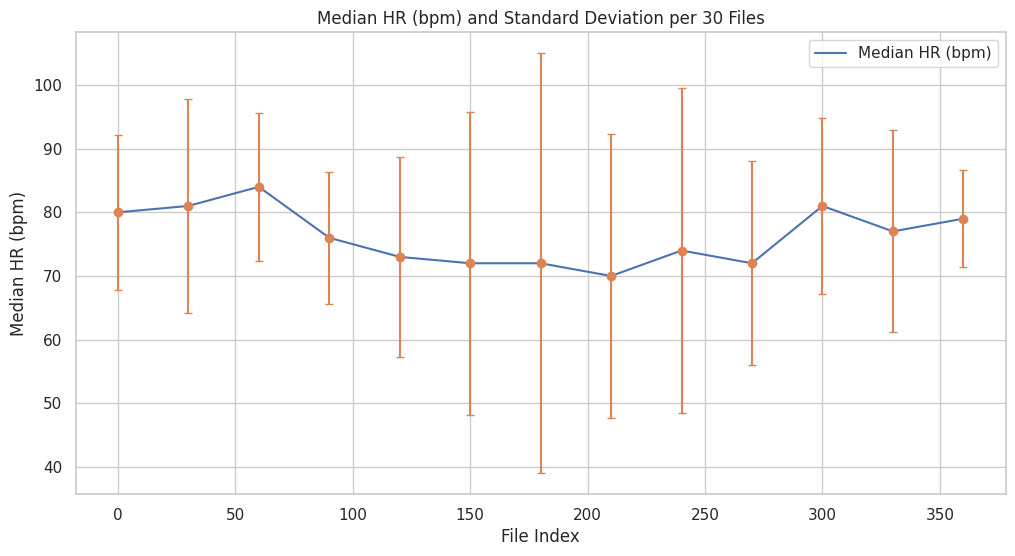

In [193]:
data_frames = []  # list to store the DataFrames

# Read each CSV file into a DataFrame
for file_name in file_names_sorted:
    file_path = os.path.join(folder_path, file_name)
    data_frame = pd.read_csv(file_path)
    data_frames.append(data_frame)

# Calculate median and standard deviation values every 30 files
median_values = []  # list to store median values
std_values = []  # list to store standard deviation values

for i in range(0, len(data_frames), 30):
    batch_data_frames = data_frames[i:i+30]
    concatenated_df = pd.concat(batch_data_frames)
    median_value = concatenated_df["HR (bpm)"].median()
    std_value = concatenated_df["HR (bpm)"].std()
    median_values.append(median_value)
    std_values.append(std_value)

# Plot the median and standard deviation values
plt.figure(figsize=(12, 6))
x = range(0, len(median_values) * 30, 30)
plt.plot(x, median_values, label='Median HR (bpm)')
plt.errorbar(x, median_values, yerr=std_values, linestyle='None', marker='o', capsize=3)
plt.xlabel("File Index")
plt.ylabel("Median HR (bpm)")
plt.title("Median HR (bpm) and Standard Deviation per 30 Files")
plt.legend()
plt.grid(True)
plt.show()


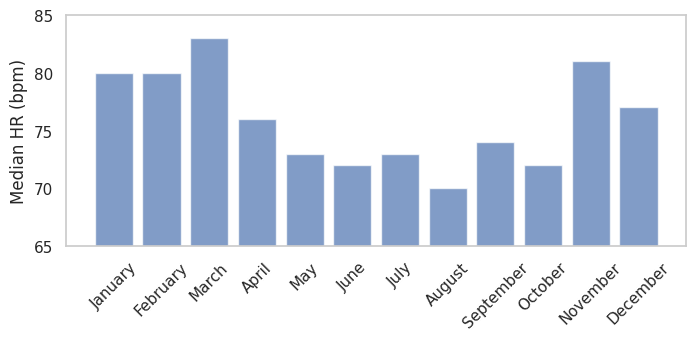

In [259]:
time_column = 'time_column'  # replace with the actual column name for the timestamp

data_frames = []  # list to store the DataFrames

# Read each CSV file into a DataFrame
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        data_frame = pd.read_csv(file_path)
        data_frames.append(data_frame)

# Concatenate all the DataFrames into a single DataFrame
concatenated_df = pd.concat(data_frames)

# Convert the 'time_column' column to datetime type
concatenated_df[time_column] = pd.to_datetime(concatenated_df[time_column])

# Extract 'Month' and 'Year' columns from the 'time_column'
concatenated_df['Month'] = concatenated_df[time_column].dt.month
concatenated_df['Year'] = concatenated_df[time_column].dt.year

# Group by 'Year' and 'Month' and calculate the median and standard deviation of 'HR (bpm)' column
monthly_summary = concatenated_df.groupby(['Year', 'Month'])['HR (bpm)'].agg(['median', 'std']).reset_index()

# Create a new 'MonthName' column for better visualization
monthly_summary['MonthName'] = monthly_summary['Month'].apply(lambda x: calendar.month_name[x])

# Create a formatted 'MonthYear' column to sort in chronological order
monthly_summary['MonthYearFormatted'] = monthly_summary['Year'].astype(str) + '-' + monthly_summary['Month'].astype(str).str.zfill(2)

# Sort the data by the formatted 'MonthYear' column
monthly_summary.sort_values('MonthYearFormatted', inplace=True)

# Plot the bar chart with error bars for monthly medians and standard deviations
plt.figure(figsize=(8, 3))
x = monthly_summary['MonthName']
y = monthly_summary['median']
error = monthly_summary['std']
plt.bar(x, y, capsize=4, alpha=0.7)
#plt.xlabel("Month")
plt.ylabel("Median HR (bpm)")
plt.ylim(65,85)
plt.xlim(-1,12)
plt.xticks(rotation=45)
plt.grid(False)

# Adjust figure margins to accommodate labels
plt.margins(2.5, 2.5)

plt.savefig("hr_mean_month.png", dpi=600, bbox_inches='tight')

plt.show()


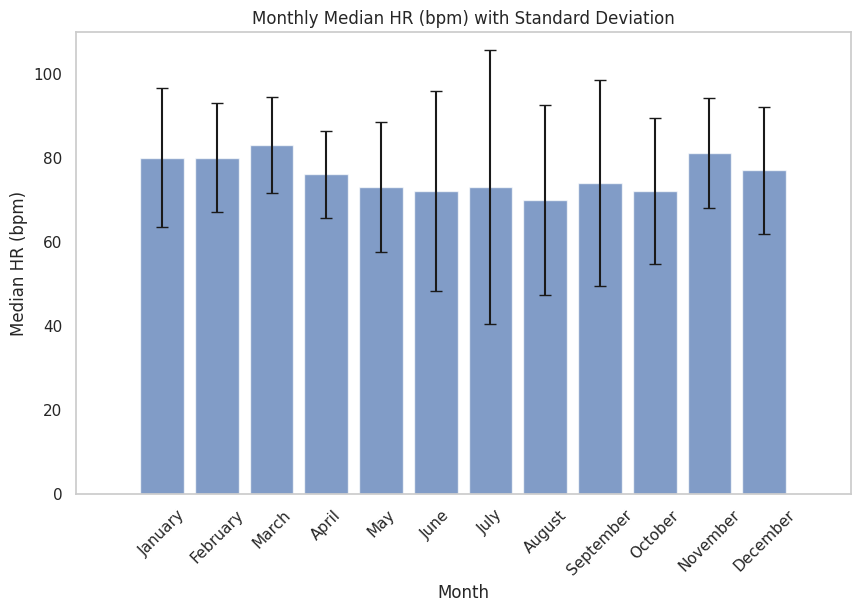

In [211]:
time_column = 'time_column'  # replace with the actual column name for the timestamp

data_frames = []  # list to store the DataFrames

# Read each CSV file into a DataFrame
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        data_frame = pd.read_csv(file_path)
        data_frames.append(data_frame)

# Concatenate all the DataFrames into a single DataFrame
concatenated_df = pd.concat(data_frames)

# Convert the 'time_column' column to datetime type
concatenated_df[time_column] = pd.to_datetime(concatenated_df[time_column])

# Extract 'Month' and 'Year' columns from the 'time_column'
concatenated_df['Month'] = concatenated_df[time_column].dt.month
concatenated_df['Year'] = concatenated_df[time_column].dt.year

# Group by 'Year' and 'Month' and calculate the median and standard deviation of 'HR (bpm)' column
monthly_summary = concatenated_df.groupby(['Year', 'Month'])['HR (bpm)'].agg(['median', 'std']).reset_index()

# Create a new 'MonthName' column for better visualization
monthly_summary['MonthName'] = monthly_summary['Month'].apply(lambda x: calendar.month_name[x])

# Create a formatted 'MonthYear' column to sort in chronological order
monthly_summary['MonthYearFormatted'] = monthly_summary['Year'].astype(str) + '-' + monthly_summary['Month'].astype(str).str.zfill(2)

# Sort the data by the formatted 'MonthYear' column
monthly_summary.sort_values('MonthYearFormatted', inplace=True)

# Plot the bar chart with error bars for monthly medians and standard deviations
plt.figure(figsize=(10, 6))
x = monthly_summary['MonthName']
y = monthly_summary['median']
error = monthly_summary['std']
plt.bar(x, y, yerr=error, capsize=4, alpha=0.7)
plt.xlabel("Month")
plt.ylabel("Median HR (bpm)")
plt.title("Monthly Median HR (bpm) with Standard Deviation")
plt.ylim(0,110)
plt.xticks(rotation=45)
plt.grid(False)

# Adjust figure margins to accommodate labels
plt.margins(0.1, 0.1)

plt.savefig("hr_mean_month.png", dpi=600)

plt.show()


## Export median values

In [328]:
# Get the list of files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Calculate the median value for each column
result = {}
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    # Read only the specified columns from the CSV file
    df = pd.read_csv(file_path, usecols=["HR (bpm)", "Temperatures (C)", "time_column"])
    medians = df[["HR (bpm)", "Temperatures (C)"]].median()
    first_time_value = pd.to_datetime(df["time_column"].iloc[0])
    medians["time_column"] = first_time_value
    result[file] = medians

# Create a new DataFrame using the calculated medians
result_df = pd.DataFrame(result).T  # Transpose the DataFrame

# Sort the index from low to high
result_df = result_df.sort_index()

# Save the new DataFrame to a file
result_df.to_csv('output.csv', index=True)

In [329]:
result_df

,HR (bpm),Temperatures (C),time_column
stillstanding001_watch.csv,73.0,25.3,2023-01-01 11:02:19
stillstanding002_watch.csv,85.0,25.1,2023-01-02 11:59:38
stillstanding003_watch.csv,63.0,20.6,2023-01-03 11:35:54
stillstanding004_watch.csv,84.0,21.9,2023-01-04 12:34:31
stillstanding005_watch.csv,95.0,26.1,2023-01-05 11:44:05
...,...,...,...
stillstanding361_watch.csv,76.0,25.1,2023-12-27 15:33:02
stillstanding362_watch.csv,72.0,23.5,2023-12-28 12:45:13
stillstanding363_watch.csv,80.0,26.5,2023-12-29 14:59:22
stillstanding364_watch.csv,86.0,23.7,2023-12-30 14:56:22


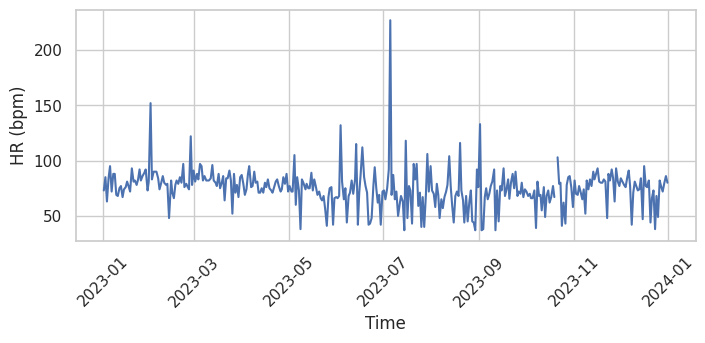

In [331]:
plt.figure(figsize=(8, 3))

# Plotting the "HR (bpm)" values against time
plt.plot(result_df['time_column'], result_df['HR (bpm)'])
plt.xlabel('Time')
plt.ylabel('HR (bpm)')
#plt.title('HR (bpm) vs. Time')
plt.xticks(rotation=45)
plt.show()

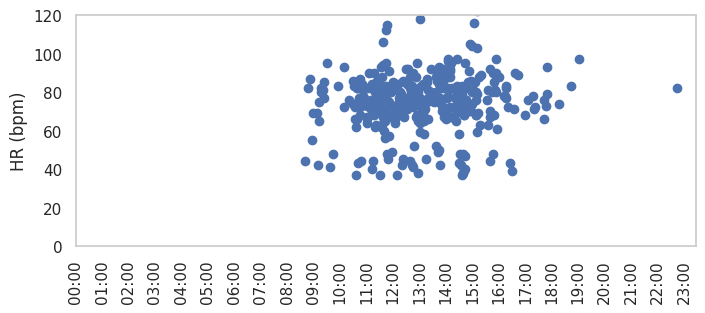

In [340]:
# Convert the "time_column" to datetime format
result_df['time_column'] = pd.to_datetime(result_df['time_column'])

# Extract the hour and minute from the datetime
result_df['hour'] = result_df['time_column'].dt.hour
result_df['minute'] = result_df['time_column'].dt.minute

plt.figure(figsize=(8, 3))
# Plotting the "HR (bpm)" values against the hour and minute
plt.scatter(result_df['hour'] + result_df['minute'] / 60, result_df['HR (bpm)'])
#plt.xlabel('Time (Hour:Minute)')
plt.ylabel('HR (bpm)')
#plt.title('HR (bpm) vs. Time')
plt.xticks(range(24), [f"{h:02d}:00" for h in range(24)])  # Set x-axis tick labels

fig.autofmt_xdate()
plt.xticks(rotation=90) # Rotate x-axis labels by 90 degrees

plt.ylim(0, 120)
plt.grid(False)

plt.savefig("hr_median_24h.png", dpi=300, bbox_inches='tight')
plt.show()

## Temperature

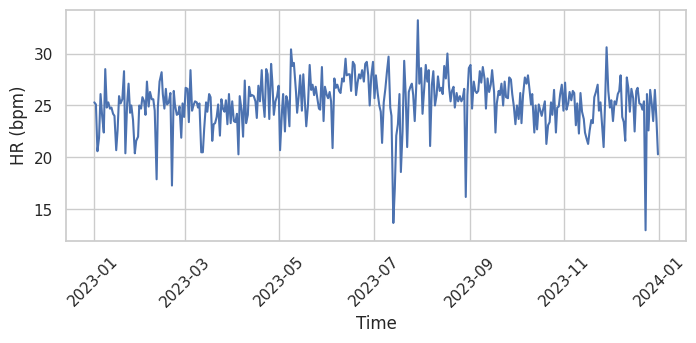

In [345]:
plt.figure(figsize=(8, 3))

# Plotting the "HR (bpm)" values against time
plt.plot(result_df['time_column'], result_df['Temperatures (C)'])
plt.xlabel('Time')
plt.ylabel('HR (bpm)')
#plt.title('HR (bpm) vs. Time')
plt.xticks(rotation=45)
plt.show()

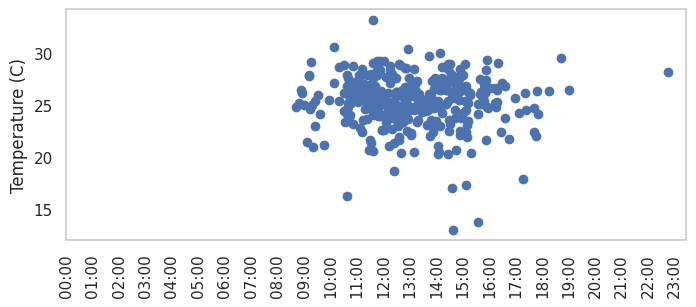

In [347]:
# Convert the "time_column" to datetime format
result_df['time_column'] = pd.to_datetime(result_df['time_column'])

# Extract the hour and minute from the datetime
result_df['hour'] = result_df['time_column'].dt.hour
result_df['minute'] = result_df['time_column'].dt.minute

plt.figure(figsize=(8, 3))
# Plotting the "HR (bpm)" values against the hour and minute
plt.scatter(result_df['hour'] + result_df['minute'] / 60, result_df['Temperatures (C)'])
#plt.xlabel('Time (Hour:Minute)')
plt.ylabel('Temperature (C)')
#plt.title('HR (bpm) vs. Time')
plt.xticks(range(24), [f"{h:02d}:00" for h in range(24)])  # Set x-axis tick labels

fig.autofmt_xdate()
plt.xticks(rotation=90) # Rotate x-axis labels by 90 degrees

#plt.ylim(0, 120)
plt.grid(False)

plt.savefig("temperature_median_24h.png", dpi=300, bbox_inches='tight')
plt.show()

In [334]:
# Get a list of all CSV file paths in the folder
csv_files = glob.glob('polar-clean/*.csv')

# Load the CSV files into a single DataFrame
df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

# Drop rows with missing values
df.dropna(subset=['HR (bpm)', 'Time'], inplace=True)

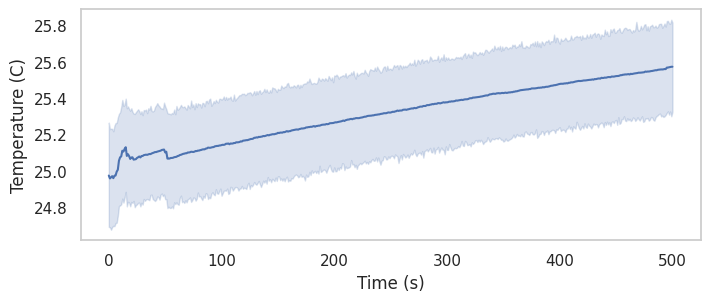

In [335]:
# Perform linear regression
regression_model = LinearRegression()
regression_model.fit(df[['Time']], df['Temperatures (C)'])

# Generate the predicted values based on the linear regression model
df['Predicted_HR'] = regression_model.predict(df[['Time']])

plt.figure(figsize=(8, 3))

# Plot scatterplot and regression line
sns.lineplot(x='Time', y='Temperatures (C)', data=df)
#sns.lineplot(x='Time', y='Predicted_HR', data=df, color='red')

# Set plot title and labels
#plt.title('Linear Regression of HR values over Time')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
# Turn off the grid
plt.grid(False)

plt.savefig('temperature_all_mean.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

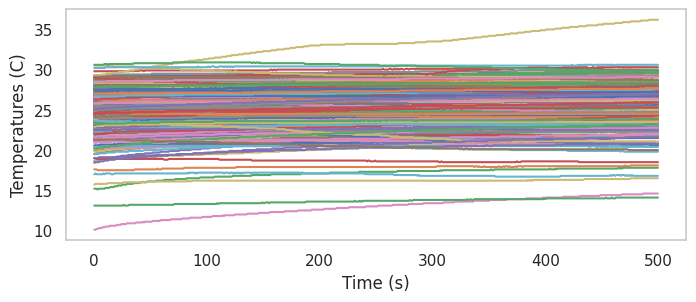

In [344]:
# Prepare an empty list to store all HR values
all_hr_data = []

plt.figure(figsize=(8, 3))

# Iterate over each CSV file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file and extract the HR column
        df = pd.read_csv(file_path)
        hr_data = df['Temperatures (C)']
        
        # Plot HR values from current file
        plt.plot(hr_data)

# Set labels and title for the plot
plt.xlabel('Time (s)')
plt.ylabel('Temperatures (C)')
#plt.title('HR (bpm) values')
# Turn off the grid
plt.grid(False)

plt.savefig('temperature_all.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()